In [1]:
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt

from transformers import BertConfig
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

from models import BertForDiffusion, DiffusionLM
from data_utils import load_e2enlg_dataset_and_tokenizer, E2enlgDataset, load_rocstories_dataset_and_tokenizer, RocstoriesDataset
from noise_schedule import get_named_beta_schedule
from train_utils import train, evaluate

%matplotlib inline

In [2]:
# dataset args
max_len = 72    # maximum length of input_ids
vocab_threshold = 10    # occurrence time < threshold token as [UNK]
test_size = 0.1     # size of evaluation dataset

# training args
batch_size = 64
device = torch.device("cuda:0")
lr = 2e-4
num_epoch = 50
weight_decay = 0
num_warmup_steps = 100

# model args
word_embedding_dim = 128
# hidden_size = 768
# num_hidden_layers = 12
# num_attention_heads = 12
# intermediate_size = 3072
hidden_size = 512
num_hidden_layers = 4
num_attention_heads = 8
intermediate_size = 2048
max_position_embeddings = max_len

In [3]:
tokenized_rocstories_dataset, tokenizer = load_rocstories_dataset_and_tokenizer(max_len=max_len, vocab_threshold=vocab_threshold)

rev_tokenizer = {v: k for k, v in tokenizer.items()}

train_set, eval_set = train_test_split(tokenized_rocstories_dataset, test_size=test_size, shuffle=True)

train_dataset = RocstoriesDataset(data_lst=train_set['input_ids'], attention_mask_lst=train_set['attention_mask'])
print("Training set size:",len(train_dataset))
eval_dataset = RocstoriesDataset(data_lst=eval_set['input_ids'], attention_mask_lst=eval_set['attention_mask'])
print("Evaluation set size:", len(eval_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

No config specified, defaulting to: roc_stories/all
Reusing dataset roc_stories (/home/dingyizhou/.cache/huggingface/datasets/wza___roc_stories/all/2.1.0/43e2851d9f31e08e4b2dd07a8057ed7a64cbb25cc7105d09856c14e638695506)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/98161 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?ba/s]

Training set size: 88344
Evaluation set size: 9817


In [4]:
config = BertConfig(vocab_size=len(tokenizer), hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads, intermediate_size=intermediate_size, max_position_embeddings=max_position_embeddings, pad_token_id=tokenizer['[PAD]'])

config.T = 2000
config.word_embedding_dim = word_embedding_dim

print(config)

BertConfig {
  "T": 2000,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 72,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 11831,
  "word_embedding_dim": 128
}



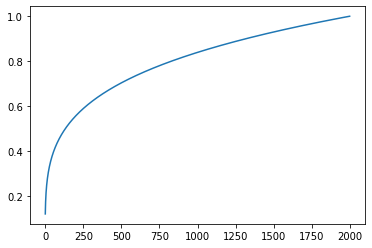

In [6]:
betas = torch.Tensor(get_named_beta_schedule(schedule_name="sqrt", num_diffusion_timesteps=config.T))
# betas = torch.Tensor(get_named_beta_schedule(schedule_name="linear", num_diffusion_timesteps=config.T))

alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, dim=0)
sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar)
plt.plot(sqrt_one_minus_alphas_bar)

In [7]:
diffusion_model = DiffusionLM(config=config, betas=betas, use_shared_weight=True, lm_head_bias=False, add_emb_noise=False).to(device)

print("Diffusion model #parameters:")
print(sum([p.numel() for p in diffusion_model.parameters()]))

optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epoch*len(train_dataloader))

Diffusion model #parameters:
15147520


In [8]:
loss_terms_dict_lst = []
progress_bar = tqdm(range(num_epoch*len(train_dataloader)))

for epoch in range(num_epoch):
    print("epoch:",epoch+1)
    loss_terms_dict_lst.append(train(diffusion_model=diffusion_model, dataloader=train_dataloader, optimizer=optimizer, scheduler=scheduler ,progress_bar=progress_bar ,verbose=True))
    evaluate(diffusion_model=diffusion_model, dataloader=eval_dataloader,)

  0%|          | 0/69050 [00:00<?, ?it/s]

epoch: 1
step: 100
mse  training loss=0.76369
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 200
mse  training loss=0.46891
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 300
mse  training loss=0.38310
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 400
mse  training loss=0.34066
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 500
mse  training loss=0.31846
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 600
mse  training loss=0.30500
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 700
mse  training loss=0.28796
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 800
mse  training loss=0.27772
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 900
mse  training loss=0.26611
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 1000
mse  training loss=0.25230
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 1100
mse  training loss=

  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.21630
epoch: 2
step: 100
mse  training loss=0.22619
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 200
mse  training loss=0.22395
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 300
mse  training loss=0.22028
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 400
mse  training loss=0.21163
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 500
mse  training loss=0.21174
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 600
mse  training loss=0.20775
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 700
mse  training loss=0.20603
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 800
mse  training loss=0.20076
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 900
mse  training loss=0.19987
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 1000
mse  training loss=0.19819
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 1100
m

  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.17575
epoch: 3
step: 100
mse  training loss=0.18534
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 200
mse  training loss=0.17901
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 300
mse  training loss=0.18168
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 400
mse  training loss=0.17692
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 500
mse  training loss=0.17666
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 600
mse  training loss=0.17602
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 700
mse  training loss=0.17502
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 800
mse  training loss=0.17424
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 900
mse  training loss=0.17162
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 1000
mse  training loss=0.16382
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 1100
m

  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.15423
epoch: 4
step: 100
mse  training loss=0.16050
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 200
mse  training loss=0.16131
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 300
mse  training loss=0.15863
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 400
mse  training loss=0.15609
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 500
mse  training loss=0.15874
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 600
mse  training loss=0.15534
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 700
mse  training loss=0.15486
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 800
mse  training loss=0.15390
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 900
mse  training loss=0.15366
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 1000
mse  training loss=0.15372
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 1100
m

  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.13970
epoch: 5
step: 100
mse  training loss=0.14552
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 200
mse  training loss=0.14378
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 300
mse  training loss=0.14382
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 400
mse  training loss=0.14528
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 500
mse  training loss=0.14206
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 600
mse  training loss=0.13875
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 700
mse  training loss=0.14147
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 800
mse  training loss=0.13966
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 900
mse  training loss=0.13669
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 1000
mse  training loss=0.13855
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 1100
m

  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.12707
epoch: 6
step: 100
mse  training loss=0.13245
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 200
mse  training loss=0.13062
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 300
mse  training loss=0.13080
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 400
mse  training loss=0.13050
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 500
mse  training loss=0.13259
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 600
mse  training loss=0.13083
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 700
mse  training loss=0.12923
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 800
mse  training loss=0.12679
L_T  training loss=0.00000
rounding  training loss=0.00000
step: 900
mse  training loss=0.12793
L_T  training loss=0.00000
rounding  training loss=0.00001
step: 1000
mse  training loss=0.12796
L_T  training loss=0.00000
rounding  training loss=0.00001
step: 1100
m

  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.11929
epoch: 7
step: 100
mse  training loss=0.12445
L_T  training loss=0.00000
rounding  training loss=0.00001
step: 200
mse  training loss=0.12130
L_T  training loss=0.00000
rounding  training loss=0.00001
step: 300
mse  training loss=0.12083
L_T  training loss=0.00000
rounding  training loss=0.00001
step: 400
mse  training loss=0.12002
L_T  training loss=0.00000
rounding  training loss=0.00002
step: 500
mse  training loss=0.12075
L_T  training loss=0.00000
rounding  training loss=0.00002
step: 600
mse  training loss=0.12040
L_T  training loss=0.00000
rounding  training loss=0.00002
step: 700
mse  training loss=0.11698
L_T  training loss=0.00000
rounding  training loss=0.00002
step: 800
mse  training loss=0.11813
L_T  training loss=0.00000
rounding  training loss=0.00002
step: 900
mse  training loss=0.11544
L_T  training loss=0.00000
rounding  training loss=0.00003
step: 1000
mse  training loss=0.11398
L_T  training loss=0.00000
rounding  training loss=0.00003
step: 1100
m

  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.10959
epoch: 8
step: 100
mse  training loss=0.11267
L_T  training loss=0.00000
rounding  training loss=0.00005
step: 200
mse  training loss=0.11190
L_T  training loss=0.00000
rounding  training loss=0.00005
step: 300
mse  training loss=0.11204
L_T  training loss=0.00000
rounding  training loss=0.00006
step: 400
mse  training loss=0.10975
L_T  training loss=0.00000
rounding  training loss=0.00006
step: 500
mse  training loss=0.10988
L_T  training loss=0.00000
rounding  training loss=0.00007
step: 600
mse  training loss=0.10786
L_T  training loss=0.00000
rounding  training loss=0.00008
step: 700
mse  training loss=0.10988
L_T  training loss=0.00000
rounding  training loss=0.00008
step: 800
mse  training loss=0.10703
L_T  training loss=0.00000
rounding  training loss=0.00009
step: 900
mse  training loss=0.10641
L_T  training loss=0.00000
rounding  training loss=0.00010
step: 1000
mse  training loss=0.10366
L_T  training loss=0.00000
rounding  training loss=0.00011
step: 1100
m

  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.09936
epoch: 9
step: 100
mse  training loss=0.10384
L_T  training loss=0.00000
rounding  training loss=0.00017
step: 200
mse  training loss=0.10355
L_T  training loss=0.00000
rounding  training loss=0.00019
step: 300
mse  training loss=0.10156
L_T  training loss=0.00000
rounding  training loss=0.00021
step: 400
mse  training loss=0.10132
L_T  training loss=0.00000
rounding  training loss=0.00022
step: 500
mse  training loss=0.10046
L_T  training loss=0.00000
rounding  training loss=0.00024
step: 600
mse  training loss=0.09852
L_T  training loss=0.00000
rounding  training loss=0.00026
step: 700
mse  training loss=0.09936
L_T  training loss=0.00000
rounding  training loss=0.00027
step: 800
mse  training loss=0.09772
L_T  training loss=0.00000
rounding  training loss=0.00029
step: 900
mse  training loss=0.09922
L_T  training loss=0.00000
rounding  training loss=0.00031
step: 1000
mse  training loss=0.09674
L_T  training loss=0.00000
rounding  training loss=0.00033
step: 1100
m

  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.09135
epoch: 10
step: 100
mse  training loss=0.09458
L_T  training loss=0.00000
rounding  training loss=0.00043
step: 200
mse  training loss=0.09396
L_T  training loss=0.00000
rounding  training loss=0.00045
step: 300
mse  training loss=0.09289
L_T  training loss=0.00000
rounding  training loss=0.00047
step: 400
mse  training loss=0.09224
L_T  training loss=0.00000
rounding  training loss=0.00049
step: 500
mse  training loss=0.09092
L_T  training loss=0.00000
rounding  training loss=0.00051
step: 600
mse  training loss=0.09004
L_T  training loss=0.00000
rounding  training loss=0.00053
step: 700
mse  training loss=0.08995
L_T  training loss=0.00000
rounding  training loss=0.00054
step: 800
mse  training loss=0.08867
L_T  training loss=0.00000
rounding  training loss=0.00056
step: 900
mse  training loss=0.08828
L_T  training loss=0.00000
rounding  training loss=0.00058
step: 1000
mse  training loss=0.08878
L_T  training loss=0.00000
rounding  training loss=0.00060
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.08481
epoch: 11
step: 100
mse  training loss=0.08644
L_T  training loss=0.00000
rounding  training loss=0.00073
step: 200
mse  training loss=0.08657
L_T  training loss=0.00000
rounding  training loss=0.00074
step: 300
mse  training loss=0.08588
L_T  training loss=0.00000
rounding  training loss=0.00077
step: 400
mse  training loss=0.08350
L_T  training loss=0.00000
rounding  training loss=0.00079
step: 500
mse  training loss=0.08520
L_T  training loss=0.00000
rounding  training loss=0.00081
step: 600
mse  training loss=0.08572
L_T  training loss=0.00000
rounding  training loss=0.00085
step: 700
mse  training loss=0.08270
L_T  training loss=0.00000
rounding  training loss=0.00087
step: 800
mse  training loss=0.08316
L_T  training loss=0.00000
rounding  training loss=0.00089
step: 900
mse  training loss=0.08193
L_T  training loss=0.00000
rounding  training loss=0.00091
step: 1000
mse  training loss=0.08299
L_T  training loss=0.00000
rounding  training loss=0.00094
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.07990
epoch: 12
step: 100
mse  training loss=0.07875
L_T  training loss=0.00000
rounding  training loss=0.00103
step: 200
mse  training loss=0.07989
L_T  training loss=0.00000
rounding  training loss=0.00103
step: 300
mse  training loss=0.07933
L_T  training loss=0.00000
rounding  training loss=0.00106
step: 400
mse  training loss=0.07933
L_T  training loss=0.00000
rounding  training loss=0.00108
step: 500
mse  training loss=0.07768
L_T  training loss=0.00000
rounding  training loss=0.00109
step: 600
mse  training loss=0.07900
L_T  training loss=0.00000
rounding  training loss=0.00109
step: 700
mse  training loss=0.07782
L_T  training loss=0.00000
rounding  training loss=0.00111
step: 800
mse  training loss=0.07725
L_T  training loss=0.00000
rounding  training loss=0.00114
step: 900
mse  training loss=0.07789
L_T  training loss=0.00000
rounding  training loss=0.00115
step: 1000
mse  training loss=0.07636
L_T  training loss=0.00000
rounding  training loss=0.00118
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.07409
epoch: 13
step: 100
mse  training loss=0.07476
L_T  training loss=0.00000
rounding  training loss=0.00122
step: 200
mse  training loss=0.07378
L_T  training loss=0.00000
rounding  training loss=0.00123
step: 300
mse  training loss=0.07462
L_T  training loss=0.00000
rounding  training loss=0.00127
step: 400
mse  training loss=0.07437
L_T  training loss=0.00000
rounding  training loss=0.00129
step: 500
mse  training loss=0.07339
L_T  training loss=0.00000
rounding  training loss=0.00131
step: 600
mse  training loss=0.07261
L_T  training loss=0.00000
rounding  training loss=0.00130
step: 700
mse  training loss=0.07286
L_T  training loss=0.00000
rounding  training loss=0.00132
step: 800
mse  training loss=0.07172
L_T  training loss=0.00000
rounding  training loss=0.00132
step: 900
mse  training loss=0.07160
L_T  training loss=0.00000
rounding  training loss=0.00133
step: 1000
mse  training loss=0.07118
L_T  training loss=0.00000
rounding  training loss=0.00134
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.07000
epoch: 14
step: 100
mse  training loss=0.07037
L_T  training loss=0.00000
rounding  training loss=0.00141
step: 200
mse  training loss=0.07031
L_T  training loss=0.00000
rounding  training loss=0.00145
step: 300
mse  training loss=0.07005
L_T  training loss=0.00000
rounding  training loss=0.00148
step: 400
mse  training loss=0.06910
L_T  training loss=0.00000
rounding  training loss=0.00147
step: 500
mse  training loss=0.06942
L_T  training loss=0.00000
rounding  training loss=0.00148
step: 600
mse  training loss=0.06902
L_T  training loss=0.00000
rounding  training loss=0.00151
step: 700
mse  training loss=0.06833
L_T  training loss=0.00000
rounding  training loss=0.00152
step: 800
mse  training loss=0.06794
L_T  training loss=0.00000
rounding  training loss=0.00153
step: 900
mse  training loss=0.06793
L_T  training loss=0.00000
rounding  training loss=0.00153
step: 1000
mse  training loss=0.06701
L_T  training loss=0.00000
rounding  training loss=0.00154
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.06667
epoch: 15
step: 100
mse  training loss=0.06613
L_T  training loss=0.00000
rounding  training loss=0.00160
step: 200
mse  training loss=0.06573
L_T  training loss=0.00000
rounding  training loss=0.00161
step: 300
mse  training loss=0.06550
L_T  training loss=0.00000
rounding  training loss=0.00161
step: 400
mse  training loss=0.06508
L_T  training loss=0.00000
rounding  training loss=0.00163
step: 500
mse  training loss=0.06596
L_T  training loss=0.00000
rounding  training loss=0.00166
step: 600
mse  training loss=0.06465
L_T  training loss=0.00000
rounding  training loss=0.00166
step: 700
mse  training loss=0.06409
L_T  training loss=0.00000
rounding  training loss=0.00166
step: 800
mse  training loss=0.06390
L_T  training loss=0.00000
rounding  training loss=0.00165
step: 900
mse  training loss=0.06419
L_T  training loss=0.00000
rounding  training loss=0.00167
step: 1000
mse  training loss=0.06423
L_T  training loss=0.00000
rounding  training loss=0.00168
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.06326
epoch: 16
step: 100
mse  training loss=0.06244
L_T  training loss=0.00000
rounding  training loss=0.00172
step: 200
mse  training loss=0.06250
L_T  training loss=0.00000
rounding  training loss=0.00172
step: 300
mse  training loss=0.06223
L_T  training loss=0.00000
rounding  training loss=0.00174
step: 400
mse  training loss=0.06226
L_T  training loss=0.00000
rounding  training loss=0.00177
step: 500
mse  training loss=0.06246
L_T  training loss=0.00000
rounding  training loss=0.00178
step: 600
mse  training loss=0.06173
L_T  training loss=0.00000
rounding  training loss=0.00178
step: 700
mse  training loss=0.06208
L_T  training loss=0.00000
rounding  training loss=0.00181
step: 800
mse  training loss=0.06116
L_T  training loss=0.00000
rounding  training loss=0.00180
step: 900
mse  training loss=0.06179
L_T  training loss=0.00000
rounding  training loss=0.00181
step: 1000
mse  training loss=0.06120
L_T  training loss=0.00000
rounding  training loss=0.00181
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.06109
epoch: 17
step: 100
mse  training loss=0.06002
L_T  training loss=0.00000
rounding  training loss=0.00184
step: 200
mse  training loss=0.06012
L_T  training loss=0.00000
rounding  training loss=0.00185
step: 300
mse  training loss=0.06022
L_T  training loss=0.00000
rounding  training loss=0.00185
step: 400
mse  training loss=0.05989
L_T  training loss=0.00000
rounding  training loss=0.00188
step: 500
mse  training loss=0.05904
L_T  training loss=0.00000
rounding  training loss=0.00187
step: 600
mse  training loss=0.06101
L_T  training loss=0.00000
rounding  training loss=0.00191
step: 700
mse  training loss=0.06028
L_T  training loss=0.00000
rounding  training loss=0.00193
step: 800
mse  training loss=0.06012
L_T  training loss=0.00000
rounding  training loss=0.00192
step: 900
mse  training loss=0.05945
L_T  training loss=0.00000
rounding  training loss=0.00192
step: 1000
mse  training loss=0.05954
L_T  training loss=0.00000
rounding  training loss=0.00192
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05958
epoch: 18
step: 100
mse  training loss=0.05896
L_T  training loss=0.00000
rounding  training loss=0.00196
step: 200
mse  training loss=0.05823
L_T  training loss=0.00000
rounding  training loss=0.00195
step: 300
mse  training loss=0.05880
L_T  training loss=0.00000
rounding  training loss=0.00195
step: 400
mse  training loss=0.05867
L_T  training loss=0.00000
rounding  training loss=0.00196
step: 500
mse  training loss=0.05788
L_T  training loss=0.00000
rounding  training loss=0.00196
step: 600
mse  training loss=0.05821
L_T  training loss=0.00000
rounding  training loss=0.00195
step: 700
mse  training loss=0.05738
L_T  training loss=0.00000
rounding  training loss=0.00194
step: 800
mse  training loss=0.05818
L_T  training loss=0.00000
rounding  training loss=0.00197
step: 900
mse  training loss=0.05824
L_T  training loss=0.00000
rounding  training loss=0.00199
step: 1000
mse  training loss=0.05700
L_T  training loss=0.00000
rounding  training loss=0.00198
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05852
epoch: 19
step: 100
mse  training loss=0.05740
L_T  training loss=0.00000
rounding  training loss=0.00198
step: 200
mse  training loss=0.05773
L_T  training loss=0.00000
rounding  training loss=0.00201
step: 300
mse  training loss=0.05699
L_T  training loss=0.00000
rounding  training loss=0.00200
step: 400
mse  training loss=0.05739
L_T  training loss=0.00000
rounding  training loss=0.00203
step: 500
mse  training loss=0.05720
L_T  training loss=0.00000
rounding  training loss=0.00203
step: 600
mse  training loss=0.05691
L_T  training loss=0.00000
rounding  training loss=0.00201
step: 700
mse  training loss=0.05703
L_T  training loss=0.00000
rounding  training loss=0.00204
step: 800
mse  training loss=0.05610
L_T  training loss=0.00000
rounding  training loss=0.00201
step: 900
mse  training loss=0.05693
L_T  training loss=0.00000
rounding  training loss=0.00202
step: 1000
mse  training loss=0.05679
L_T  training loss=0.00000
rounding  training loss=0.00205
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05675
epoch: 20
step: 100
mse  training loss=0.05651
L_T  training loss=0.00000
rounding  training loss=0.00205
step: 200
mse  training loss=0.05564
L_T  training loss=0.00000
rounding  training loss=0.00205
step: 300
mse  training loss=0.05542
L_T  training loss=0.00000
rounding  training loss=0.00205
step: 400
mse  training loss=0.05613
L_T  training loss=0.00000
rounding  training loss=0.00204
step: 500
mse  training loss=0.05576
L_T  training loss=0.00000
rounding  training loss=0.00207
step: 600
mse  training loss=0.05598
L_T  training loss=0.00000
rounding  training loss=0.00208
step: 700
mse  training loss=0.05468
L_T  training loss=0.00000
rounding  training loss=0.00207
step: 800
mse  training loss=0.05535
L_T  training loss=0.00000
rounding  training loss=0.00205
step: 900
mse  training loss=0.05523
L_T  training loss=0.00000
rounding  training loss=0.00206
step: 1000
mse  training loss=0.05493
L_T  training loss=0.00000
rounding  training loss=0.00204
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05556
epoch: 21
step: 100
mse  training loss=0.05472
L_T  training loss=0.00000
rounding  training loss=0.00206
step: 200
mse  training loss=0.05467
L_T  training loss=0.00000
rounding  training loss=0.00204
step: 300
mse  training loss=0.05479
L_T  training loss=0.00000
rounding  training loss=0.00208
step: 400
mse  training loss=0.05449
L_T  training loss=0.00000
rounding  training loss=0.00207
step: 500
mse  training loss=0.05456
L_T  training loss=0.00000
rounding  training loss=0.00206
step: 600
mse  training loss=0.05500
L_T  training loss=0.00000
rounding  training loss=0.00208
step: 700
mse  training loss=0.05382
L_T  training loss=0.00000
rounding  training loss=0.00206
step: 800
mse  training loss=0.05384
L_T  training loss=0.00000
rounding  training loss=0.00204
step: 900
mse  training loss=0.05401
L_T  training loss=0.00000
rounding  training loss=0.00204
step: 1000
mse  training loss=0.05420
L_T  training loss=0.00000
rounding  training loss=0.00208
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05519
epoch: 22
step: 100
mse  training loss=0.05354
L_T  training loss=0.00000
rounding  training loss=0.00209
step: 200
mse  training loss=0.05440
L_T  training loss=0.00000
rounding  training loss=0.00207
step: 300
mse  training loss=0.05362
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 400
mse  training loss=0.05370
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 500
mse  training loss=0.05396
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 600
mse  training loss=0.05331
L_T  training loss=0.00000
rounding  training loss=0.00209
step: 700
mse  training loss=0.05323
L_T  training loss=0.00000
rounding  training loss=0.00207
step: 800
mse  training loss=0.05404
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 900
mse  training loss=0.05304
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 1000
mse  training loss=0.05300
L_T  training loss=0.00000
rounding  training loss=0.00208
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05483
epoch: 23
step: 100
mse  training loss=0.05281
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.05335
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 300
mse  training loss=0.05276
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 400
mse  training loss=0.05310
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 500
mse  training loss=0.05285
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 600
mse  training loss=0.05221
L_T  training loss=0.00000
rounding  training loss=0.00209
step: 700
mse  training loss=0.05283
L_T  training loss=0.00000
rounding  training loss=0.00209
step: 800
mse  training loss=0.05216
L_T  training loss=0.00000
rounding  training loss=0.00208
step: 900
mse  training loss=0.05287
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 1000
mse  training loss=0.05324
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05384
epoch: 24
step: 100
mse  training loss=0.05248
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 200
mse  training loss=0.05224
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 300
mse  training loss=0.05289
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 400
mse  training loss=0.05189
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 500
mse  training loss=0.05254
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 600
mse  training loss=0.05292
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 700
mse  training loss=0.05258
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 800
mse  training loss=0.05251
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 900
mse  training loss=0.05218
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1000
mse  training loss=0.05136
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05312
epoch: 25
step: 100
mse  training loss=0.05208
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 200
mse  training loss=0.05137
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 300
mse  training loss=0.05180
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.05232
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 500
mse  training loss=0.05182
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 600
mse  training loss=0.05208
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 700
mse  training loss=0.05155
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 800
mse  training loss=0.05123
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.05127
L_T  training loss=0.00000
rounding  training loss=0.00209
step: 1000
mse  training loss=0.05159
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05244
epoch: 26
step: 100
mse  training loss=0.05173
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 200
mse  training loss=0.05152
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 300
mse  training loss=0.05200
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 400
mse  training loss=0.05166
L_T  training loss=0.00000
rounding  training loss=0.00216
step: 500
mse  training loss=0.05165
L_T  training loss=0.00000
rounding  training loss=0.00216
step: 600
mse  training loss=0.05148
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 700
mse  training loss=0.05121
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 800
mse  training loss=0.05179
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 900
mse  training loss=0.05090
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 1000
mse  training loss=0.05121
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05263
epoch: 27
step: 100
mse  training loss=0.05107
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 200
mse  training loss=0.05109
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 300
mse  training loss=0.05067
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 400
mse  training loss=0.05062
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 500
mse  training loss=0.05041
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 600
mse  training loss=0.05146
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 700
mse  training loss=0.05148
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 800
mse  training loss=0.05123
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 900
mse  training loss=0.05053
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 1000
mse  training loss=0.05080
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05207
epoch: 28
step: 100
mse  training loss=0.05045
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 200
mse  training loss=0.05112
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 300
mse  training loss=0.04967
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 400
mse  training loss=0.05083
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 500
mse  training loss=0.05059
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 600
mse  training loss=0.05051
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 700
mse  training loss=0.05037
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 800
mse  training loss=0.05079
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 900
mse  training loss=0.05003
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1000
mse  training loss=0.05101
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05150
epoch: 29
step: 100
mse  training loss=0.04989
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 200
mse  training loss=0.04982
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 300
mse  training loss=0.05076
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 400
mse  training loss=0.04991
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 500
mse  training loss=0.04962
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 600
mse  training loss=0.05012
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 700
mse  training loss=0.05032
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 800
mse  training loss=0.04993
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 900
mse  training loss=0.05006
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 1000
mse  training loss=0.05001
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05140
epoch: 30
step: 100
mse  training loss=0.05062
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.04993
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 300
mse  training loss=0.05058
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 400
mse  training loss=0.04994
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 500
mse  training loss=0.04923
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 600
mse  training loss=0.04966
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 700
mse  training loss=0.04926
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 800
mse  training loss=0.04969
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 900
mse  training loss=0.04965
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1000
mse  training loss=0.04898
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05040
epoch: 31
step: 100
mse  training loss=0.05015
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 200
mse  training loss=0.04952
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 300
mse  training loss=0.04942
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 400
mse  training loss=0.04964
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 500
mse  training loss=0.04958
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 600
mse  training loss=0.04958
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 700
mse  training loss=0.04888
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 800
mse  training loss=0.04963
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.05001
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 1000
mse  training loss=0.04941
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.05075
epoch: 32
step: 100
mse  training loss=0.04912
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 200
mse  training loss=0.04880
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 300
mse  training loss=0.04916
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 400
mse  training loss=0.04876
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 500
mse  training loss=0.04891
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 600
mse  training loss=0.04918
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 700
mse  training loss=0.04939
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 800
mse  training loss=0.04912
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 900
mse  training loss=0.04890
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 1000
mse  training loss=0.04945
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04997
epoch: 33
step: 100
mse  training loss=0.04892
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 200
mse  training loss=0.04931
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 300
mse  training loss=0.04932
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 400
mse  training loss=0.04883
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 500
mse  training loss=0.04941
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 600
mse  training loss=0.04888
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 700
mse  training loss=0.04920
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 800
mse  training loss=0.04922
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 900
mse  training loss=0.04857
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 1000
mse  training loss=0.04864
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04999
epoch: 34
step: 100
mse  training loss=0.04859
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.04864
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 300
mse  training loss=0.04962
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 400
mse  training loss=0.04849
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 500
mse  training loss=0.04883
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 600
mse  training loss=0.04907
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 700
mse  training loss=0.04924
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 800
mse  training loss=0.04862
L_T  training loss=0.00000
rounding  training loss=0.00215
step: 900
mse  training loss=0.04894
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 1000
mse  training loss=0.04855
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04975
epoch: 35
step: 100
mse  training loss=0.04903
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 200
mse  training loss=0.04819
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 300
mse  training loss=0.04906
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 400
mse  training loss=0.04889
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 500
mse  training loss=0.04876
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 600
mse  training loss=0.04851
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 700
mse  training loss=0.04800
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 800
mse  training loss=0.04816
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.04888
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1000
mse  training loss=0.04853
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04974
epoch: 36
step: 100
mse  training loss=0.04838
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 200
mse  training loss=0.04861
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 300
mse  training loss=0.04869
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.04882
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 500
mse  training loss=0.04834
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 600
mse  training loss=0.04881
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 700
mse  training loss=0.04828
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 800
mse  training loss=0.04837
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.04794
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1000
mse  training loss=0.04793
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04978
epoch: 37
step: 100
mse  training loss=0.04817
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 200
mse  training loss=0.04866
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 300
mse  training loss=0.04884
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 400
mse  training loss=0.04855
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 500
mse  training loss=0.04872
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 600
mse  training loss=0.04813
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 700
mse  training loss=0.04880
L_T  training loss=0.00000
rounding  training loss=0.00214
step: 800
mse  training loss=0.04792
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 900
mse  training loss=0.04779
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1000
mse  training loss=0.04834
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04957
epoch: 38
step: 100
mse  training loss=0.04786
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.04764
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 300
mse  training loss=0.04799
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.04783
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 500
mse  training loss=0.04824
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 600
mse  training loss=0.04814
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 700
mse  training loss=0.04804
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 800
mse  training loss=0.04785
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 900
mse  training loss=0.04815
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 1000
mse  training loss=0.04831
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04940
epoch: 39
step: 100
mse  training loss=0.04766
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 200
mse  training loss=0.04882
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 300
mse  training loss=0.04822
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 400
mse  training loss=0.04730
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 500
mse  training loss=0.04802
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 600
mse  training loss=0.04837
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 700
mse  training loss=0.04797
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 800
mse  training loss=0.04809
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.04868
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1000
mse  training loss=0.04804
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04952
epoch: 40
step: 100
mse  training loss=0.04784
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.04795
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 300
mse  training loss=0.04840
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.04800
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 500
mse  training loss=0.04821
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 600
mse  training loss=0.04816
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 700
mse  training loss=0.04795
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 800
mse  training loss=0.04785
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 900
mse  training loss=0.04835
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1000
mse  training loss=0.04781
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04939
epoch: 41
step: 100
mse  training loss=0.04790
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 200
mse  training loss=0.04744
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 300
mse  training loss=0.04800
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.04809
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 500
mse  training loss=0.04749
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 600
mse  training loss=0.04828
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 700
mse  training loss=0.04735
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 800
mse  training loss=0.04817
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 900
mse  training loss=0.04791
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1000
mse  training loss=0.04795
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04944
epoch: 42
step: 100
mse  training loss=0.04777
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.04759
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 300
mse  training loss=0.04808
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 400
mse  training loss=0.04802
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 500
mse  training loss=0.04869
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 600
mse  training loss=0.04759
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 700
mse  training loss=0.04792
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 800
mse  training loss=0.04746
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.04837
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1000
mse  training loss=0.04807
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04918
epoch: 43
step: 100
mse  training loss=0.04774
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.04798
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 300
mse  training loss=0.04788
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 400
mse  training loss=0.04805
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 500
mse  training loss=0.04781
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 600
mse  training loss=0.04763
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 700
mse  training loss=0.04745
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 800
mse  training loss=0.04754
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 900
mse  training loss=0.04807
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 1000
mse  training loss=0.04803
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04891
epoch: 44
step: 100
mse  training loss=0.04681
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 200
mse  training loss=0.04750
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 300
mse  training loss=0.04790
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.04758
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 500
mse  training loss=0.04832
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 600
mse  training loss=0.04729
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 700
mse  training loss=0.04785
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 800
mse  training loss=0.04712
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.04770
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1000
mse  training loss=0.04740
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04866
epoch: 45
step: 100
mse  training loss=0.04799
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.04789
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 300
mse  training loss=0.04778
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.04802
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 500
mse  training loss=0.04768
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 600
mse  training loss=0.04776
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 700
mse  training loss=0.04753
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 800
mse  training loss=0.04801
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.04749
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1000
mse  training loss=0.04856
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04906
epoch: 46
step: 100
mse  training loss=0.04794
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.04732
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 300
mse  training loss=0.04775
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.04778
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 500
mse  training loss=0.04736
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 600
mse  training loss=0.04746
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 700
mse  training loss=0.04768
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 800
mse  training loss=0.04881
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.04805
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1000
mse  training loss=0.04732
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04896
epoch: 47
step: 100
mse  training loss=0.04755
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 200
mse  training loss=0.04732
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 300
mse  training loss=0.04749
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.04772
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 500
mse  training loss=0.04792
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 600
mse  training loss=0.04767
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 700
mse  training loss=0.04791
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 800
mse  training loss=0.04897
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.04733
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1000
mse  training loss=0.04739
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04926
epoch: 48
step: 100
mse  training loss=0.04821
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 200
mse  training loss=0.04827
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 300
mse  training loss=0.04770
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 400
mse  training loss=0.04805
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 500
mse  training loss=0.04799
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 600
mse  training loss=0.04722
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 700
mse  training loss=0.04719
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 800
mse  training loss=0.04767
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 900
mse  training loss=0.04790
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 1000
mse  training loss=0.04793
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04907
epoch: 49
step: 100
mse  training loss=0.04748
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.04837
L_T  training loss=0.00000
rounding  training loss=0.00213
step: 300
mse  training loss=0.04729
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.04769
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 500
mse  training loss=0.04777
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 600
mse  training loss=0.04822
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 700
mse  training loss=0.04746
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 800
mse  training loss=0.04771
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 900
mse  training loss=0.04696
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1000
mse  training loss=0.04754
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04872
epoch: 50
step: 100
mse  training loss=0.04747
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 200
mse  training loss=0.04773
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 300
mse  training loss=0.04776
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 400
mse  training loss=0.04782
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 500
mse  training loss=0.04777
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 600
mse  training loss=0.04797
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 700
mse  training loss=0.04741
L_T  training loss=0.00000
rounding  training loss=0.00212
step: 800
mse  training loss=0.04776
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 900
mse  training loss=0.04733
L_T  training loss=0.00000
rounding  training loss=0.00211
step: 1000
mse  training loss=0.04728
L_T  training loss=0.00000
rounding  training loss=0.00210
step: 1100


  0%|          | 0/154 [00:00<?, ?it/s]

eval loss=0.04901


In [19]:
torch.save(diffusion_model.state_dict(), "checkpoints/epoch50_unshared_dim24.pth")

In [9]:
loss_terms_dict = {'mse':[], 'L_T':[], 'rounding':[]}
for key in loss_terms_dict_lst[0].keys():
    for ep in range(num_epoch):
        loss_terms_dict[key] += loss_terms_dict_lst[ep][key]

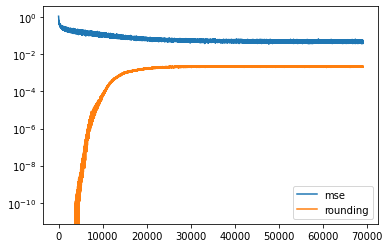

In [10]:
plt.plot(loss_terms_dict['mse'], label='mse')
plt.plot(loss_terms_dict['rounding'], label='rounding')
plt.legend()
plt.yscale('log')

In [7]:
diffusion_model.load_state_dict(torch.load("checkpoints/roc_unshared_dim128.pth"))

<All keys matched successfully>

In [11]:
x_T = torch.randn(size=(batch_size, max_len, word_embedding_dim))

In [12]:
logits, hidden_states = diffusion_model.sample(x_T.to(device), return_hidden_states=True, verbose=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
sample_idx = 62
for step in [0,1000,1500,1800,1900,1950,1990,1995,1998,1999]:
    hidden_state = hidden_states[step][sample_idx]
    with torch.no_grad():
        hidden_logits = diffusion_model.lm_head(hidden_state)
        sampled_ids = torch.argmax(hidden_logits,dim=-1).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("step:", step)
        print(" ".join(sampled_seq))

step: 0
exchanging Kacie eyebrow [START] rec Darius Emil ) Cher Lamar blimp blimp Darren irate hikers unicorn Cammie docks hummingbird Emil Celine Becka PhD Cherry outer reveal blaring ipod legos Seamus Remi mexico slimy Addison demonstrated Chet sucker RN ATV housekeeper tick Cass Buttons visitor Celine Micah infestation hack females Pierre despised Woody Too thorough Ellis Reuben wives reference manufacturing Mika cornbread geese artistic Playstation midway Jemma vendors curl bay goats jogger Duncan
step: 1000
[START] Cancun Mika girly kayaks Yvonne Su renowned Cliff squirmed igloo Oswald she bladder ref Grady Velma convert Myra Loki while Floyd Tessa connections Giants the Cedric margaritas flinched quieter goose bats Brownie enlisted Veronica Luther Silas Gertrude once patron Tinder Young thump Vick was Lanie Jocelyn [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
step: 1500
[START

In [15]:
for sample_idx in range(batch_size):
    hidden_state = hidden_states[-1][sample_idx]
    with torch.no_grad():
        hidden_logits = diffusion_model.lm_head(hidden_state)
        sampled_ids = torch.argmax(hidden_logits,dim=-1).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("sample_idx:", sample_idx)
        print(" ".join(sampled_seq))

sample_idx: 0
[START] Jason 's his father was day . He called his friends brother inside to see a bit . Jason was a lot day at the shirt . a lot of appointment and they cleaned the whole store . Jason walked all the baby of same proud of their cream . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 1
[START] The falling driver took him to the street . Suddenly , Ted was a mom while apologized the band was with them . She wanted to do some careful and fell on . Ted 's wife was taking [UNK] to the arm thermos . Ted almost were the rest of burned again was out the song . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 2
[START] Kia was working married . She found out in T . She forgot eating early and started to get better . She felt on her back and started walking to dance that . Kia went out a not alarm [UNK] blimp . [END] [PAD] [PAD] [PAD] [PAD] [PAD

In [17]:
diffusion_model.config.word_embedding_dim

128

In [16]:
logits2, hidden_states2 = diffusion_model.sample(x_T.to(device), clamp='rounding', return_hidden_states=True, verbose=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
for sample_idx in range(32):
    hidden_state = hidden_states2[-1][sample_idx]
    with torch.no_grad():
        hidden_logits = diffusion_model.lm_head(hidden_state)
        sampled_ids = torch.argmax(hidden_logits,dim=-1).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("sample_idx:", sample_idx)
        print(" ".join(sampled_seq))

sample_idx: 0
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 1
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 2
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [18]:
for n,p in diffusion_model.named_parameters():
    print(n)

word_embeddings.weight
lm_head.bias
model.encoder.layer.0.attention.self.query.weight
model.encoder.layer.0.attention.self.query.bias
model.encoder.layer.0.attention.self.key.weight
model.encoder.layer.0.attention.self.key.bias
model.encoder.layer.0.attention.self.value.weight
model.encoder.layer.0.attention.self.value.bias
model.encoder.layer.0.attention.output.dense.weight
model.encoder.layer.0.attention.output.dense.bias
model.encoder.layer.0.attention.output.LayerNorm.weight
model.encoder.layer.0.attention.output.LayerNorm.bias
model.encoder.layer.0.intermediate.dense.weight
model.encoder.layer.0.intermediate.dense.bias
model.encoder.layer.0.output.dense.weight
model.encoder.layer.0.output.dense.bias
model.encoder.layer.0.output.LayerNorm.weight
model.encoder.layer.0.output.LayerNorm.bias
model.encoder.layer.1.attention.self.query.weight
model.encoder.layer.1.attention.self.query.bias
model.encoder.layer.1.attention.self.key.weight
model.encoder.layer.1.attention.self.key.bias
mode

In [15]:
diffusion_model.betas

tensor([0.0146, 0.0089, 0.0071,  ..., 0.3572, 0.5556, 0.9990], device='cuda:1')

In [14]:
diffusion_model.word_embeddings.weight

Parameter containing:
tensor([[ 0.2217,  0.0254,  0.4711,  ...,  0.3230,  0.3838,  0.7482],
        [ 0.0882,  1.0620,  0.5003,  ...,  0.6159,  0.3964,  0.6374],
        [ 0.4291,  0.2313,  0.5281,  ...,  0.7738,  0.3877,  0.7236],
        ...,
        [-0.0897, -0.9293, -0.8582,  ...,  0.3125,  0.8776,  0.1680],
        [ 0.1854,  0.0403, -0.2973,  ...,  0.3295,  0.4081,  0.3254],
        [-0.3223, -0.1760,  0.1167,  ...,  0.2682,  0.5546,  0.2844]],
       device='cuda:0', requires_grad=True)

In [15]:
diffusion_model.lm_head.weight

Parameter containing:
tensor([[ 0.2217,  0.0254,  0.4711,  ...,  0.3230,  0.3838,  0.7482],
        [ 0.0882,  1.0620,  0.5003,  ...,  0.6159,  0.3964,  0.6374],
        [ 0.4291,  0.2313,  0.5281,  ...,  0.7738,  0.3877,  0.7236],
        ...,
        [-0.0897, -0.9293, -0.8582,  ...,  0.3125,  0.8776,  0.1680],
        [ 0.1854,  0.0403, -0.2973,  ...,  0.3295,  0.4081,  0.3254],
        [-0.3223, -0.1760,  0.1167,  ...,  0.2682,  0.5546,  0.2844]],
       device='cuda:0', requires_grad=True)

In [16]:
diffusion_model.word_embeddings.weight[3]

tensor([ 3.6980e-01,  1.4281e-02,  8.5134e-01,  4.6347e-01,  8.3883e-02,
        -5.2226e-01, -1.1526e-01, -4.1208e-01, -1.9577e-01,  6.2380e-01,
        -2.6762e-01,  4.4332e-01, -9.8043e-01,  4.9860e-01, -2.0108e-02,
         1.1695e+00, -2.7346e-01, -2.1597e-01, -5.3292e-01,  4.1682e-01,
        -9.3909e-01,  6.1473e-01, -2.9377e-01,  1.1352e+00,  8.1860e-02,
        -1.8189e-01,  3.6770e-01,  8.8562e-02,  2.9779e-01,  7.9326e-01,
        -1.5170e-01,  2.6372e-01,  7.0391e-01,  4.8530e-01, -1.2471e-01,
        -7.3973e-01, -6.7852e-01,  2.4380e-01,  6.1742e-01,  2.6714e-01,
         7.7159e-02, -1.3679e-01, -2.5824e-01,  4.2884e-01,  3.4468e-01,
        -6.4796e-02,  3.2856e-01, -3.2289e-01, -3.0372e-01, -6.2548e-01,
         2.5278e-01,  2.4888e-01, -1.6193e+00, -3.0788e-01,  1.0746e+00,
         3.9899e-01, -2.5974e-01, -2.6729e-01, -1.2117e-02,  2.3565e-01,
        -4.8559e-02,  6.6479e-03, -2.5953e-01, -3.3761e-01, -2.2743e-01,
         1.5445e-01, -9.6112e-01,  4.0863e-01,  7.8

In [17]:
diffusion_model.lm_head

Linear(in_features=128, out_features=11831, bias=False)

In [25]:
print(diffusion_model.lm_head.bias.data[:10])

tensor([ 4.3935,  4.4273,  3.1125,  4.4660, -2.4534,  1.5366, -0.5221,  0.9753,
        -3.2307,  5.0618], device='cuda:0')


In [18]:
learned_emb = diffusion_model.word_embeddings.weight.data.cpu().numpy()

In [19]:
learned_emb.shape

(11831, 128)

In [50]:
emb_2d = TSNE(learning_rate='auto').fit_transform(learned_emb)

/home/dingyizhou/anaconda3/envs/gen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [51]:
emb_2d.shape

(852, 2)

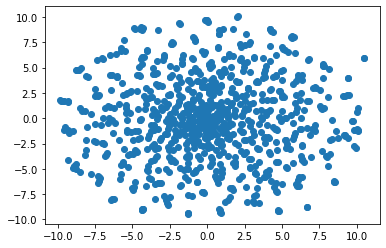

In [53]:
plt.scatter(x=emb_2d[:,0], y=emb_2d[:,1])

In [20]:
learned_rounding = diffusion_model.lm_head.weight.data.cpu().numpy()

In [21]:
learned_rounding.shape

(11831, 128)

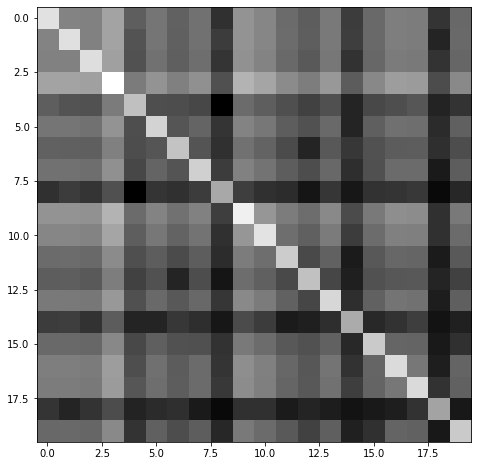

In [22]:
plt.figure(figsize=(8,8))
plt.imshow(np.matmul(learned_emb[:20,:], learned_rounding[:20,:].T), cmap='gray')

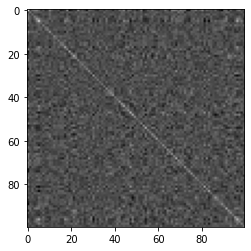

In [12]:
t = torch.randn(size=(100,10))
plt.imshow(torch.matmul(t, t.T), cmap='gray')